
## Fitting a linear regression model with TF Eager

**Goal:** In this notebook you will see how to use TF Eager to fit the parameters (slope and intercept) of a simple linear regression model via gradient descent (GD). 

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Dataset:** You work again with the systolic blood pressure and age data of 33 American women, which is generated and visualized in the upper part of the notebook.

* fit a linear model via the sklearn machine learning library of python to get the fitted values of the intercept and slope as reference. 

* use the tensorflow library and enable the tf eager mode to fit the parameters of the simple linear model via GD with the objective to minimize the MSE loss. 
    * define the mse loss function 
    * apply the gradients_function of tf eager on the loss w.r.t. the parameters
    * use the gradients to update the parameter values via update formula
    * iterate over the two former steps for many steps and check the current values of the estimated model parameters and the loss after each updatestep 
    * verify that the estimated parameter values converge to the values which you got from the sklearn fit.  


[open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_03/nb_ch03_06.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.linear_model import LinearRegression

Here we read in the systolic blood pressure and the age of the 33 American women in our dataset. Then we use the sklearn library to find the optimal values for the slope a and the intercept b.

In [2]:
# Blood Pressure data
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9, 
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114, 
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217] 
x = np.asarray(x, np.float32) 
y = np.asarray(y, np.float32)

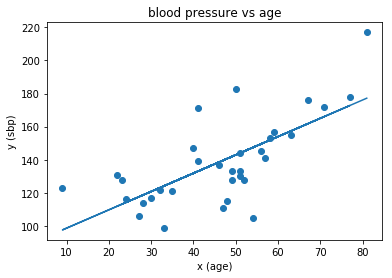

intercept =  87.67143 solpe =  1.1050216


In [3]:
plt.scatter(x=x,y=y)
plt.title("blood pressure vs age")
plt.xlabel("x (age)")
plt.ylabel("y (sbp)")

model = LinearRegression()
res = model.fit(x.reshape((len(x),1)), y)
predictions = model.predict(x.reshape((len(x),1)))
plt.plot(x, predictions)
plt.show()
print("intercept = ",res.intercept_,"solpe = ", res.coef_[0],)

## TF Eager

Now we want to use the TF Eager mode to find the optimal parameters for the linear regression problem. First we enable the eager execution mode and define our mse loss function.

In [4]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [5]:
def loss(a, b):
  y_hat = a*x + b
  return tf.reduce_mean((y_hat - y)**2)

We can do a forwad pass and can calculate the loss (mse) with the initial values a=0 and b=139 (139 is the mean of the blood pressure and slope a=0 implies that the model predicts the mean for each age). Note that a and b must be "tfe.Variables". We see the loss value in the numpy argument in the output (In contrast to "normal" TensoFlow we dont need to run a session to get loss!).

In [6]:
loss(tfe.Variable(0.0), tfe.Variable(139.0))

<tf.Tensor: id=27, shape=(), dtype=float32, numpy=673.4545>

Now we define that we want to have the gradients of the loss w.r.t to our two model parameters, the slope a and the intercept b. In the nex cell we print the gradient of the loss w.r.t to at and gradient of the loss w.r.t to b. Note that we calculated the loss for all data points and therefore we get diffrent gradients then in nb_04, where we only used one datapoint.

In [7]:
grad_f = tfe.gradients_function(loss)

In [8]:
grad_a, grad_b = grad_f(tfe.Variable(0.0), tfe.Variable(139.0))
print(grad_a.numpy())
print(grad_b.numpy())

-553.09094
0.727273


In [9]:
a = tfe.Variable(0.0)
b = tfe.Variable(139.0)
with tf.GradientTape() as tape:
  loss_val = loss(a,b)
  print("Loss at ", loss_val)
  grad_a, grad_b = tape.gradient(loss_val, [a,b])
  print(grad_a, grad_b)

Loss at  tf.Tensor(673.4545, shape=(), dtype=float32)
tf.Tensor(-553.09094, shape=(), dtype=float32) tf.Tensor(0.727273, shape=(), dtype=float32)


Now lets use gradient descent to opimize the slope a and the intercept b. The start values are a=0 and b=139, our learning rate eta is 0.0004 and we do 80000 updatesteps with all 33 observations. 

In [10]:
a  = tfe.Variable(0.0)
b = tfe.Variable(139.0)
eta = 0.0004
for i in range(80000):
  with tf.GradientTape() as tape: #Record the gradients from now on
    y_hat = a*x + b
    loss = tf.reduce_mean((y_hat - y)**2)   
    grad_a, grad_b  = tape.gradient(loss, [a,b])
    a = tfe.Variable(a - eta * grad_a)
    b = tfe.Variable(b - eta * grad_b)

    if (i % 5000 == 0):
      print("Epoch:",i, "slope=",a.numpy(),"intercept=",b.numpy(),"gradient_a", grad_a.numpy(), "gradient_b",grad_b.numpy(), "mse=", loss.numpy())


Epoch: 0 slope= 0.22123638 intercept= 138.99971 gradient_a -553.09094 gradient_b 0.727273 mse= 673.4545
Epoch: 5000 slope= 0.47009143 intercept= 120.60784 gradient_a -0.14053345 gradient_b 7.3059855 mse= 469.57272
Epoch: 10000 slope= 0.6975813 intercept= 108.807014 gradient_a -0.09031677 gradient_b 4.688313 mse= 398.76877
Epoch: 15000 slope= 0.8435634 intercept= 101.23433 gradient_a -0.058013916 gradient_b 3.0085347 mse= 369.61255
Epoch: 20000 slope= 0.9372412 intercept= 96.37488 gradient_a -0.036483765 gradient_b 1.9306204 mse= 357.6062
Epoch: 25000 slope= 0.99735403 intercept= 93.256584 gradient_a -0.023651123 gradient_b 1.2389097 mse= 352.66214
Epoch: 30000 slope= 1.0359306 intercept= 91.25547 gradient_a -0.016540527 gradient_b 0.7949929 mse= 350.62622
Epoch: 35000 slope= 1.0606831 intercept= 89.97145 gradient_a -0.010864258 gradient_b 0.5101743 mse= 349.78793
Epoch: 40000 slope= 1.0765644 intercept= 89.14761 gradient_a -0.0056152344 gradient_b 0.32746363 mse= 349.4427
Epoch: 45000 

Lets look at the final values for the slope a,the intercept b and the mse loss. We know form the closed formula solution that:

1.   optimal value for a: 1.1050216
2.   optimal value for b: 87.67143
3.   minimal loss: 349.200787168560

After 80000 update steps we are very close to the optimal values






In [0]:
print(a.numpy(), b.numpy(), loss.numpy())

1.1041987 87.71413 349.20105
